# Compressing ip1 layer of CIFAR10 Network using Pruning, Quantization and Huffman Encoding as per the Deep Compression paper

### Load the pretrained model, solvers, and look at the shape of the model

In [9]:
!sudo ldconfig /usr/local/cuda/lib64


from pylab import *
import os
%matplotlib inline
caffe_root = '/home/super/ISHA/Deep_Learning/Caffe/caffe/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
 
import sys
sys.path.insert(0, caffe_root + 'python')
import caffe
 
GPU_ID = 2 # Switch between 0 and 1 depending on the GPU you want to use.
caffe.set_mode_gpu()
caffe.set_device(2)
os.chdir(caffe_root)
 
solver = None  # ignore this workaround for lmdb data (can't instantiate two solvers on the same data)
solver = caffe.SGDSolver('/home/super/ISHA/Deep_Learning/16Nov/neuron_wise_exhaustive/cifar10_full_solver.prototxt')
solver.net.copy_from('/home/super/ISHA/Deep_Learning/16Nov/neuron_wise_exhaustive/reference.caffemodel.h5')
 
 
[(k, v[0].data.shape) for k, v in solver.net.params.items()]
 

/sbin/ldconfig.real: /usr/local/cuda/lib64/libcudnn.so.5 is not a symbolic link

/sbin/ldconfig.real: /usr/lib/x86_64-linux-gnu/libcudnn.so.5 is not a symbolic link

/sbin/ldconfig.real: /usr/lib/nvidia-375/libEGL.so.1 is not a symbolic link

/sbin/ldconfig.real: /usr/lib32/nvidia-375/libEGL.so.1 is not a symbolic link



[('conv1', (32, 3, 5, 5)),
 ('conv2', (32, 32, 5, 5)),
 ('conv3', (64, 32, 5, 5)),
 ('ip1', (10, 1024))]

### Look at the distribution of the weights. Sort the weights by the absolute magnitude, with the most important weight being the one with the highest magnitude. Notice that most weights are concentrated near the origin, and the distribution looks like a Guassian centred at 0.

('stats for layer', 'ip1')
('max, min and mean value  of original data are ', 0.045842741, -0.025963742, 1.4842953e-10)
('max, min and mean value  of absolute value of original data  are ', 0.045842741, 1.6181093e-07, 0.0032693991)


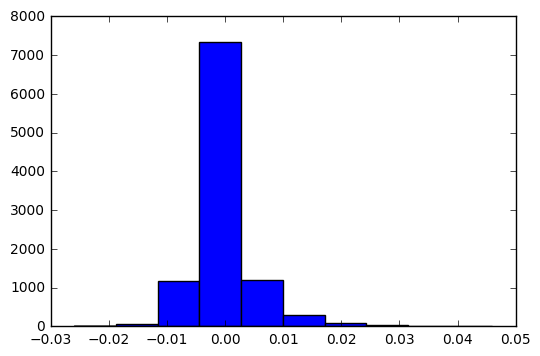

('number of non zero elements in original data are: ', 10240)
the indices of the largest 10 weights and their values are
(4, 181) 0.0458427
(1, 737) 0.0450811
(8, 597) 0.0437529
(6, 753) 0.042398
(7, 500) 0.0409227
(1, 837) 0.0397966
(6, 885) 0.0378821
(0, 917) 0.0378816
(2, 693) 0.0376152
(5, 629) 0.0370172


In [10]:
def layer_stats(solver,layername):
    print('stats for layer',layername)
    original_data=np.copy(solver.net.params[layername][0].data[:])
    absolute_orig_data=np.abs(original_data)
    print('max, min and mean value  of original data are ',np.max(original_data),np.min(original_data),np.mean(original_data))
    print('max, min and mean value  of absolute value of original data  are ',np.max(absolute_orig_data),np.min(absolute_orig_data),np.mean(absolute_orig_data))
    plt.hist(original_data.flatten(),bins=10)
    plt.show()
    
    ## Sort the weigh indices according to magnitude, in descending order
    train_abs=np.copy(absolute_orig_data)
    print('number of non zero elements in original data are: ',np.count_nonzero(train_abs))

    flat_sort_rev_trainwt=[]

    #code to rank weights
    for index, x in np.ndenumerate(train_abs):
      flat_sort_rev_trainwt.append([index,x])


    flat_sort_rev_trainwt.sort(key=lambda x: x[1],reverse=True)

    print('the indices of the largest 10 weights and their values are')
    trainwt_bottom=[]
    for i in range(10): 
      trainwt_bottom.append(flat_sort_rev_trainwt[i][0][:])
      print trainwt_bottom[-1],original_data[trainwt_bottom[-1]]
    
    return flat_sort_rev_trainwt

flat_sort_rev_trainwt= layer_stats(solver,'ip1')

## PRUNING SETUP:

#### Create a mask to mask out the weights that you want to prune out

In [11]:
def create_mask(solver,layername,num_elements_retained,flat_sort_rev_trainwt):
    mask=np.zeros(np.shape(solver.net.params[layername][0].data[:]))
    total=len(flat_sort_rev_trainwt)

    for i in range(num_elements_retained):
          mask[flat_sort_rev_trainwt[i][0]]=1


    print 'total number of elements in the layer = ' + str(total)
    print 'number of weights retained = ' + str(num_elements_retained)
    print 'non zero elements and sum of mask='+str(sum(mask))
    print 'zeroed out elements=' + str(total-sum(mask))
    
    return mask
    
mask=create_mask(solver,'ip1',100,flat_sort_rev_trainwt)

total number of elements in the layer = 10240
number of weights retained = 100
non zero elements and sum of mask=100.0
zeroed out elements=10140.0


#### Create the training and testing loops

In [12]:
#training loop
def training_loop_pruning(solver,mask,layername,niter=60000):
  print('starting training')
 # niter = 60000
  test_interval = 1000
  train_loss = zeros(niter)
  test_acc = zeros(int(np.ceil(niter / test_interval)))
  output = zeros((niter, 8, 10))

# the main solver loop
  for it in range(niter):
      solver.step(1)  # SGD by Caffe
    
    # store the train loss
      train_loss[it] = solver.net.blobs['loss'].data
    
    # store the output on the first test batch
    # (start the forward pass at ip1 to avoid loading new data)
      solver.test_nets[0].forward(start='conv1')
      output[it] = solver.test_nets[0].blobs['ip1'].data[:8]
      solver.net.params[layername][0].data[:] = solver.net.params[layername][0].data[:] * mask
        
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
      if it % test_interval == 0:
       # print 'Iteration', it, 'testing...'
       # print('nonzero in ip1 num are:',len(np.nonzero(solver.test_nets[0].params['ip1'][0].data[:])[0]))
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['ip1'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
        test_acc[it // test_interval] = correct / 1e4
  _, ax1 = subplots()
  ax2 = ax1.twinx()
  ax1.plot(arange(niter), train_loss)
  ax2.plot(test_interval * arange(len(test_acc)), test_acc, 'r')
  ax1.set_xlabel('iteration')
  ax1.set_ylabel('train loss')
  ax2.set_ylabel('test accuracy')
  ax2.set_title('Test Accuracy: {:.2f}'.format(test_acc[-1]))
  return test_acc[-1]

def train_with_mask(elements_to_retain,flat_sort_rev_trainwt,solver,layername,niter=60000):
  solver.net.copy_from('/home/super/ISHA/Deep_Learning/16Nov/neuron_wise_exhaustive/reference.caffemodel.h5')
  print('solver loaded')


  mask=np.zeros(np.shape(solver.net.params[layername][0].data[:]))
  total=len(flat_sort_rev_trainwt)
  for i in range(elements_to_retain):
    mask[flat_sort_rev_trainwt[i][0]]=1


  print 'total number of elements = '  + str(total)
  print 'thresh_percent, number of weights retained = ' + str(elements_to_retain)
  print 'non zero elements and sum of mask='+str(sum(mask))
  print 'zeroed out elements=' + str(total-sum(mask))

 
  solver.net.params[layername][0].data[:] = solver.net.params[layername][0].data[:] * mask
  print('starting training for bot_thresh=',elements_to_retain)
  test_acc=training_loop_pruning(solver,mask,layername,niter)
  print('testing accuracy is: ',test_acc)
  return test_acc

#### Test the accuracy of the pretrained model

In [13]:

solver.test_nets[0].copy_from('/home/super/ISHA/Deep_Learning/16Nov/neuron_wise_exhaustive/reference.caffemodel.h5')
#solver.test_nets[0].params['conv1'][0].data[:]=np.copy(new100)

correct = 0
for test_it in range(100):
    solver.test_nets[0].forward()
    correct += sum(solver.test_nets[0].blobs['ip1'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
print(correct/1e4)

0.7911


#### Vary pruning thresholds (number of weights you want to retain), and retrain keeping only those elements active via a mask. Decide upon the final threshold, and save the trained model weights.

('running case', 100)
solver loaded
total number of elements = 10240
thresh_percent, number of weights retained = 100
non zero elements and sum of mask=100.0
zeroed out elements=10140.0
('starting training for bot_thresh=', 100)
starting training
('testing accuracy is: ', 0.79349999999999998)
('running case', 250)
solver loaded
total number of elements = 10240
thresh_percent, number of weights retained = 250
non zero elements and sum of mask=250.0
zeroed out elements=9990.0
('starting training for bot_thresh=', 250)
starting training
('testing accuracy is: ', 0.79100000000000004)
('running case', 500)
solver loaded
total number of elements = 10240
thresh_percent, number of weights retained = 500
non zero elements and sum of mask=500.0
zeroed out elements=9740.0
('starting training for bot_thresh=', 500)
starting training
('testing accuracy is: ', 0.80010000000000003)
('running case', 750)
solver loaded
total number of elements = 10240
thresh_percent, number of weights retained = 750
no

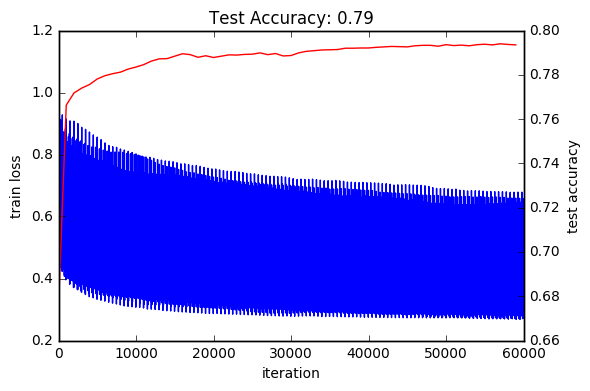

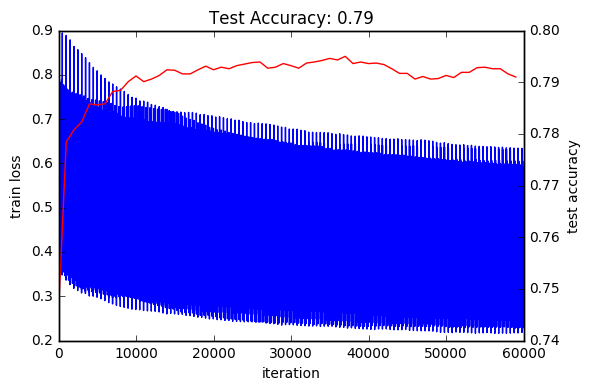

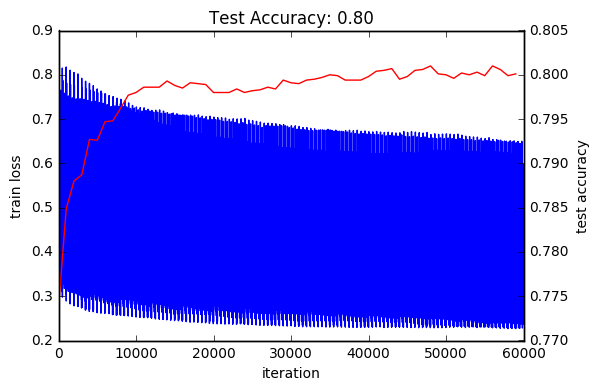

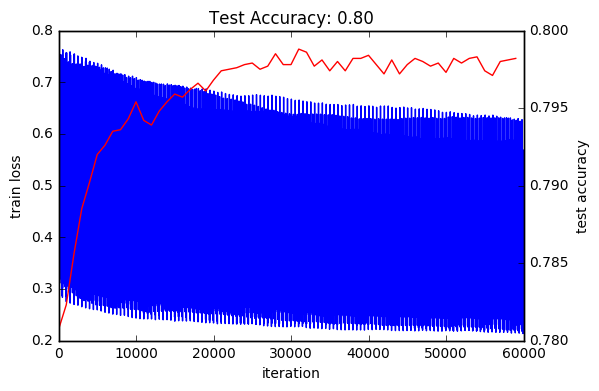

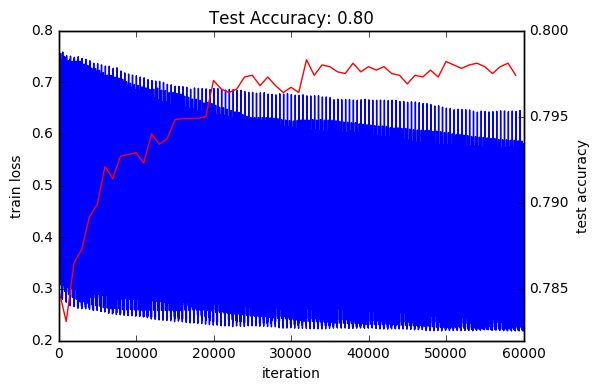

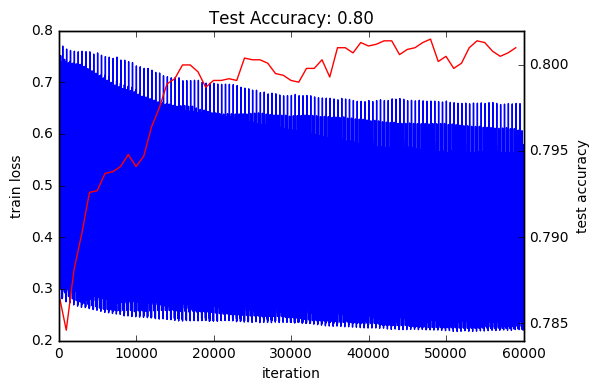

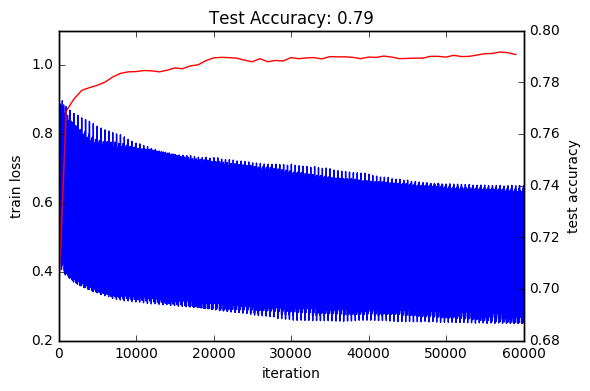

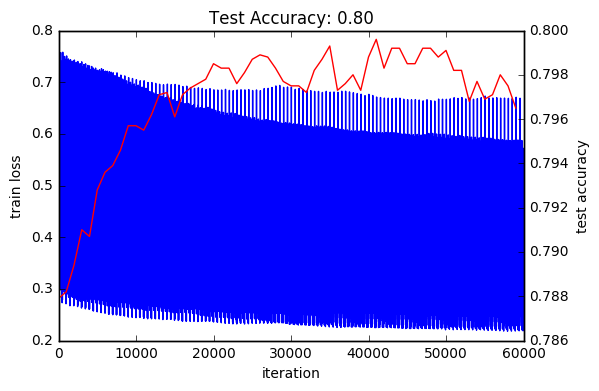

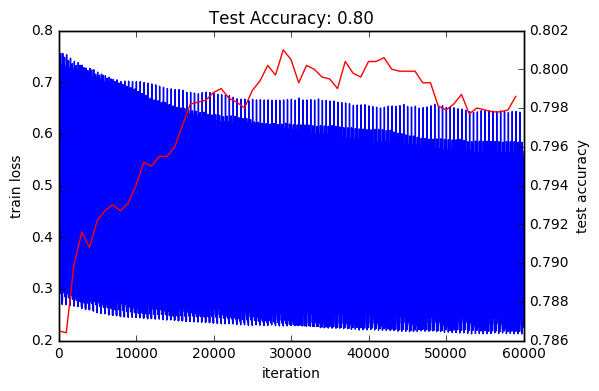

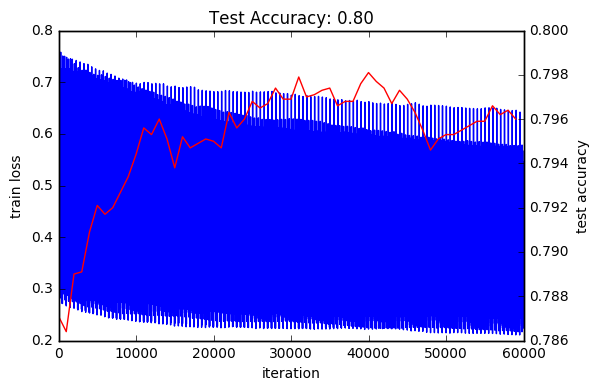

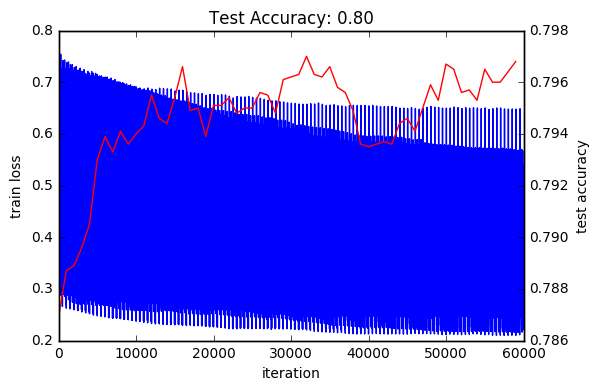

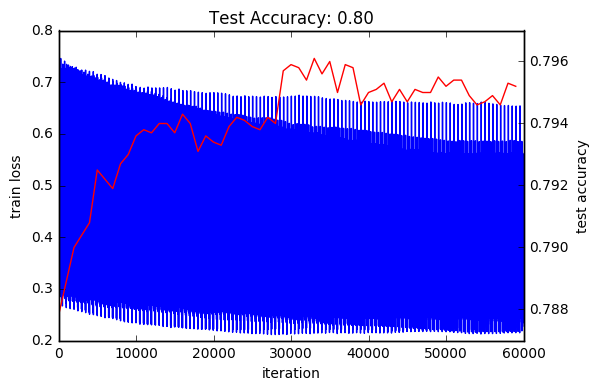

In [6]:
accuracy=[]
retained=[100,250,500,750,1000,1100,120,1300,1400,1500,1600,1700]
for retain in retained:
    print('running case',retain)
    accuracy.append(train_with_mask(retain,flat_sort_rev_trainwt,solver,'ip1',niter=60000))
    
print(accuracy)

solver loaded
total number of elements = 10240
thresh_percent, number of weights retained = 500
non zero elements and sum of mask=500.0
zeroed out elements=9740.0
('starting training for bot_thresh=', 500)
starting training
('testing accuracy is: ', 0.80020000000000002)


0.80020000000000002

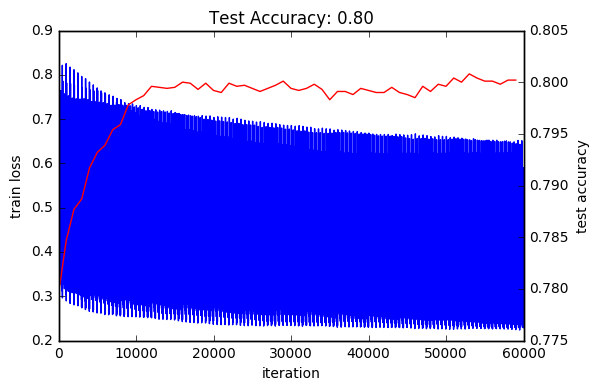

In [14]:
solver = None  # ignore this workaround for lmdb data (can't instantiate two solvers on the same data)
solver = caffe.SGDSolver('/home/super/ISHA/Deep_Learning/16Nov/neuron_wise_exhaustive/cifar10_full_solver.prototxt')
solver.net.copy_from('/home/super/ISHA/Deep_Learning/16Nov/neuron_wise_exhaustive/reference.caffemodel.h5')
 
train_with_mask(500,flat_sort_rev_trainwt,solver,'ip1',niter=60000)
    


In [15]:
original_data500=np.copy(solver.net.params['ip1'][0].data[:])
print('number of non zeros are:',len(np.nonzero(original_data500)[0]))

('number of non zeros are:', 500)


In [19]:
#retest pruned solver after loading the relevant model.


solver.net.copy_from('/home/super/ISHA/Deep_Learning/16Nov/neuron_wise_exhaustive//reference_500fc.caffemodel.h5')
solver.test_nets[0].copy_from('/home/super/ISHA/Deep_Learning/16Nov/neuron_wise_exhaustive//reference_500fc.caffemodel.h5')
solver.net.params['ip1'][0].data[:]=original_data500
print('number of nonzero weights are ',len(np.nonzero(solver.net.params['ip1'][0].data[:])[0]))


correct = 0
for test_it in range(100):
    solver.test_nets[0].forward()
    correct += sum(solver.test_nets[0].blobs['ip1'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
print('accuracy is ',correct/1e4)

('number of nonzero weights are ', 500)
('accuracy is ', 0.80159999999999998)


## QUANTIZATION SETUP


#### Save the pruned  layer weights and create the mask 

In [20]:
mask=np.zeros(np.shape(solver.net.params['ip1'][0].data[:]))
for i in range(500):
  mask[flat_sort_rev_trainwt[i][0]]=1

#### Create the quantization pipeline 

1) Cluster weights and create a codebook that stores the value of the centroids and a code that stores the index of the centroid of the cluster each weight belongs to.    
2) Quantize the weights and the gradients of the non zero values in the pruned network based on the clustered codebook and code values.      
3) Get the back-propagated gradients for all non zero weights, group them by cluster, add all the gradients within the cluster and update the cluster centroid based on the accumulated gradient for that cluster.   
4) Perform a custom version of solver.step(1) that updates the codebook manually with the gradient.    
5) Run this for all iterations and get the accuracy.    



In [24]:
# quantizer weights according to codebok and code
def quantize_weights(solver,codebook,code,layername):
    original_data=np.copy(solver.net.params[layername][0].data[:])
    weight_conv1_flattened=original_data.flatten()
    nz_idx=np.nonzero(weight_conv1_flattened)
    conv1_flat_changed=np.zeros(weight_conv1_flattened.shape)
    for idx,nzidx in enumerate(nz_idx[0]):
        conv1_flat_changed[nzidx]=codebook[code[idx]]
    conv1_changed=conv1_flat_changed.reshape(original_data.shape)
    return conv1_changed


#quantize the backward gradients
def quantize_grads(solver,code,codebook,layername):
    original_data=np.copy(solver.net.params[layername][0].data[:])
    weight_conv1_flattened=original_data.flatten()
    nz_idx=np.nonzero(weight_conv1_flattened)
    gradients=solver.net.params[layername][0].diff
    gradients_codebook=np.zeros((codebook.shape))
    grads_flatten=gradients.flatten()
    final_grads=[]
    [final_grads.append(grads_flatten[nzidx]) for nzidx in nz_idx[0]]
    for idx,grad in enumerate(final_grads):
        gradients_codebook[code[idx]]+=grad
    return gradients_codebook


#update the codebook with the cumulative gradient, sort of like a custom solver.step(1) for the codebook
def update_codebook(codebook,gradients_codebook,learning_rate,velocity,momentum):
    velocity=np.multiply(momentum,velocity)-np.multiply(learning_rate,gradients_codebook)
    codebook+=velocity
    return codebook,velocity
        
#wrap forward, backward and update step into 1 training step       
def quantized_training_step(solver,codebook,code,mask,learning_rate,velocity,momentum,layername):
    solver.step(1)
    solver.net.params[layername][0].data[:]= solver.net.params[layername][0].data[:]*mask
    gradients_codebook=quantize_grads(solver,code,codebook,layername)
    codebook,velocity=update_codebook(codebook,gradients_codebook,learning_rate,velocity,momentum)
    quantized_weights=quantize_weights(solver,codebook,code,layername)
    solver.net.params[layername][0].data[:]=np.copy(quantized_weights)
    for k, v in solver.net.params.items():
        solver.test_nets[0].params[k][0].data[:]= np.copy(v[0].data)

    
#generate codebook from kmeans clustering trained weights
#using uniform cenroid initialization as that gives best results
def cluster_trained_weights(solver,numClusters,layername):
    original_data=np.copy(solver.net.params[layername][0].data[:])
    nz_idx=np.nonzero(original_data)
    nz_data=original_data[nz_idx]
    X=nz_data.flatten()
    X=X.reshape(-1,1)
    #X=whiten(X)
    InitC=np.linspace(X.min(),X.max(),num=numClusters)
    codebook, codeX=kmeans2(X, InitC.reshape(-1,1), minit='matrix')
    #codebook, codeX=kmeans2(X, numClusters, minit='points')
    #codeX,dist=vq(X,codebook)
    #print(code.min(),code.max())
    edges_hist=[x for x in range(numClusters+1)]
    frq, edges = np.histogram(codeX,edges_hist)
    fig, ax = plt.subplots()
    ax.bar(edges[:-1], frq, width=np.diff(edges), ec="k", align="edge")
    plt.show()
    return codeX,codebook



#training loop
def training_loop(solver,niter,codebook,code,mask,learning_rate,velocity,momentum,layername):
  print('starting training')
  test_interval=1000
  train_loss = zeros(niter)
  test_acc = zeros(int(np.ceil(niter / test_interval)))
  output = zeros((niter, 8, 10))


# the main solver loop
  for it in range(niter):
    #if it>niter/2: learning_rate=learning_rate/8 #uncomment this if you need to reduce learning rate
            
    # solver.step(1)
      quantized_training_step(solver,codebook,code,mask,learning_rate,velocity,momentum,layername)  # custom SGD step for quantization
    
    # store the train loss
      train_loss[it] = solver.net.blobs['loss'].data
    # (start the forward pass at conv1 to avoid loading new data)
      solver.test_nets[0].forward(start='conv1')
      output[it] = solver.test_nets[0].blobs['ip1'].data[:8]
      solver.net.params[layername][0].data[:] = solver.net.params[layername][0].data[:]  * mask
    # run a full test every so often
      if it % test_interval == 0:
       # print 'Iteration', it, 'testing...'
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['ip1'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
        test_acc[it // test_interval] = correct / 1e4
        print('accuracy for this iteration is',correct/1e4)
    
  _, ax1 = subplots()
  ax2 = ax1.twinx()
  ax1.plot(arange(niter), train_loss)
  ax2.plot(test_interval * arange(len(test_acc)), test_acc, 'r')
  ax1.set_xlabel('iteration')
  ax1.set_ylabel('train loss')
  ax2.set_ylabel('test accuracy')
  ax2.set_title('Test Accuracy: {:.2f}'.format(test_acc[-1]))
        
  return test_acc[-1]


def refresh_solver(solver,data,reference,layername):
    solver.net.copy_from(reference)
    solver.net.params[layername][0].data[:]=np.copy(data)

def top_level_training(solver,clusters,mask,data,reference,layername,learning_rate=0.0001,momentum=0.9,niter=60000):
    refresh_solver(solver,data,reference,layername)
    print('toplevel shape nonzero is',len(np.nonzero(solver.net.params[layername][0].data[:])[0]))
    code,codebook = cluster_trained_weights(solver,clusters,layername)
    print('shape of code and codebook is ',code.shape,codebook)
    solver.net.params[layername][0].data[:]=np.copy(quantize_weights(solver,codebook,code,layername))
    print('toplevel shape nonzero is',len(np.nonzero(solver.net.params[layername][0].data[:])[0]))
    velocity=np.zeros(codebook.shape) #TODO: possible bug. Check how velocity is initialized
    quantized_training_step(solver,codebook,code,mask,learning_rate,velocity,momentum,layername)
    return training_loop(solver,niter,codebook,code,mask,learning_rate,velocity,momentum,layername)

    

    

In [25]:
# after pruning, the final threshold was chosen as 500. Use this to create a mask to simulate pruning while quantizing.
data500=original_data500
reference500='/home/super/ISHA/Deep_Learning/16Nov/neuron_wise_exhaustive/reference_500fc.caffemodel.h5'
mask500=np.zeros(np.shape(solver.net.params['ip1'][0].data[:]))
for i in range(500):
  mask500[flat_sort_rev_trainwt[i][0]]=1
    
print(len(np.nonzero(data500)[0]))


500


('running for clusters', 2)
('toplevel shape nonzero is', 500)


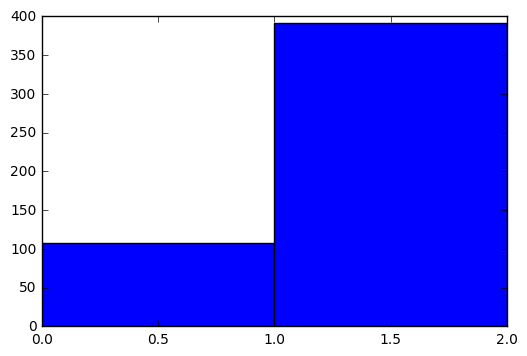

('shape of code and codebook is ', (500,), array([[-0.0110866 ],
       [ 0.02029258]], dtype=float32))
('toplevel shape nonzero is', 500)
starting training
('accuracy for this iteration is', 0.78920000000000001)
('accuracy for this iteration is', 0.7974)
('accuracy for this iteration is', 0.79610000000000003)
('accuracy for this iteration is', 0.79479999999999995)
('accuracy for this iteration is', 0.79579999999999995)
('accuracy for this iteration is', 0.79630000000000001)
('accuracy for this iteration is', 0.79600000000000004)
('accuracy for this iteration is', 0.79610000000000003)
('accuracy for this iteration is', 0.79749999999999999)
('accuracy for this iteration is', 0.79779999999999995)
('accuracy for this iteration is', 0.79710000000000003)
('accuracy for this iteration is', 0.7964)
('accuracy for this iteration is', 0.79669999999999996)
('accuracy for this iteration is', 0.79649999999999999)
('accuracy for this iteration is', 0.79679999999999995)
('accuracy for this iteration

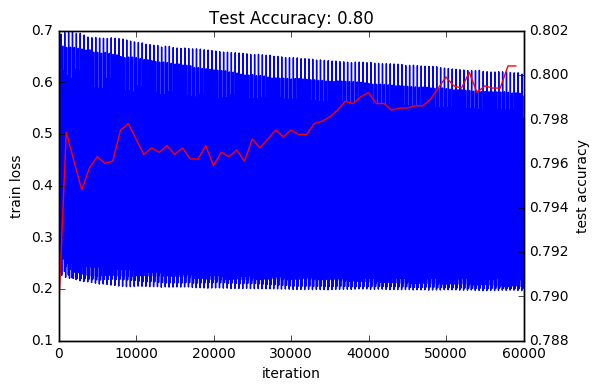

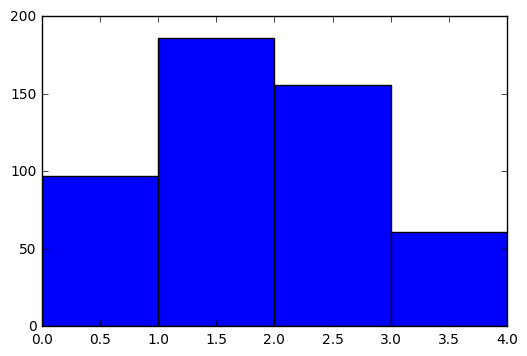

('shape of code and codebook is ', (500,), array([[-0.01268759],
       [ 0.01225248],
       [ 0.02263046],
       [ 0.03571666]], dtype=float32))
('toplevel shape nonzero is', 500)
starting training
('accuracy for this iteration is', 0.80210000000000004)
('accuracy for this iteration is', 0.80410000000000004)
('accuracy for this iteration is', 0.80320000000000003)
('accuracy for this iteration is', 0.80330000000000001)
('accuracy for this iteration is', 0.80410000000000004)
('accuracy for this iteration is', 0.80300000000000005)
('accuracy for this iteration is', 0.80189999999999995)
('accuracy for this iteration is', 0.80189999999999995)
('accuracy for this iteration is', 0.80220000000000002)
('accuracy for this iteration is', 0.80279999999999996)
('accuracy for this iteration is', 0.80169999999999997)
('accuracy for this iteration is', 0.8014)
('accuracy for this iteration is', 0.80089999999999995)
('accuracy for this iteration is', 0.80110000000000003)
('accuracy for this iteratio

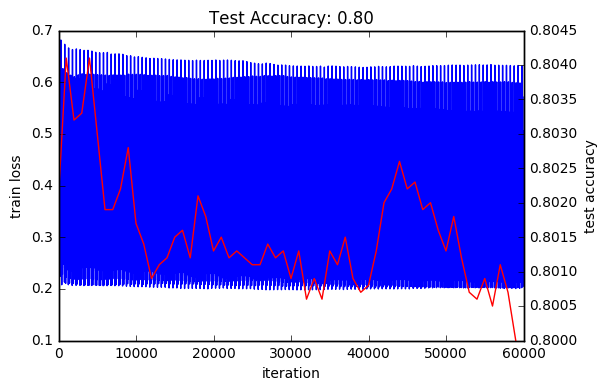

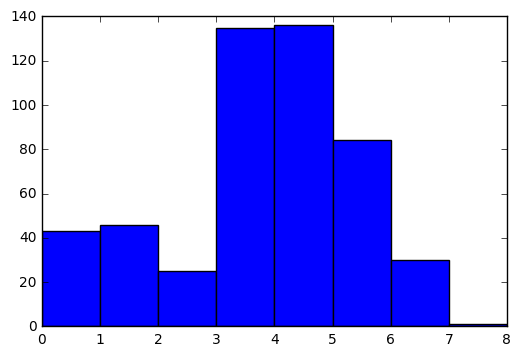

('shape of code and codebook is ', (500,), array([[-0.01748891],
       [-0.00995997],
       [ 0.00188904],
       [ 0.0122251 ],
       [ 0.01951687],
       [ 0.02824017],
       [ 0.03961268],
       [ 0.05505323]], dtype=float32))
('toplevel shape nonzero is', 500)
starting training
('accuracy for this iteration is', 0.80369999999999997)
('accuracy for this iteration is', 0.80269999999999997)
('accuracy for this iteration is', 0.80259999999999998)
('accuracy for this iteration is', 0.80349999999999999)
('accuracy for this iteration is', 0.80359999999999998)
('accuracy for this iteration is', 0.80459999999999998)
('accuracy for this iteration is', 0.80459999999999998)
('accuracy for this iteration is', 0.8054)
('accuracy for this iteration is', 0.80500000000000005)
('accuracy for this iteration is', 0.80549999999999999)
('accuracy for this iteration is', 0.80669999999999997)
('accuracy for this iteration is', 0.80640000000000001)
('accuracy for this iteration is', 0.806200000000000

/home/super/.local/lib/python2.7/site-packages/scipy/cluster/vq.py:653: UserWarning: One of the clusters is empty. Re-run kmean with a different initialization.
  warnings.warn("One of the clusters is empty. "


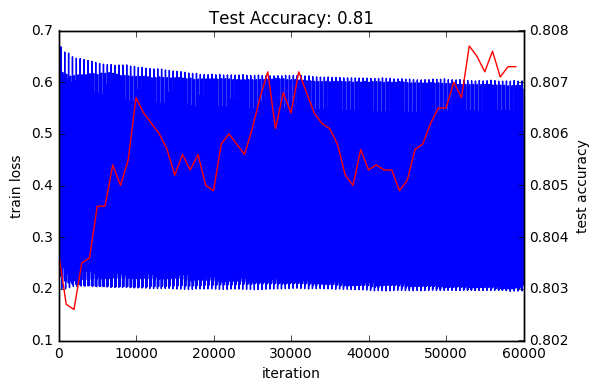

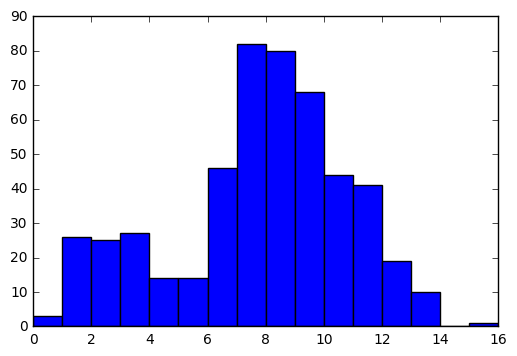

('shape of code and codebook is ', (500,), array([[-0.02450648],
       [-0.01806622],
       [-0.01393635],
       [-0.00994992],
       [-0.00490168],
       [ 0.00261225],
       [ 0.00869892],
       [ 0.01333993],
       [ 0.01717717],
       [ 0.02155704],
       [ 0.02611404],
       [ 0.03066453],
       [ 0.03804216],
       [ 0.04314897],
       [ 0.04967044],
       [ 0.05505323]], dtype=float32))
('toplevel shape nonzero is', 500)
starting training
('accuracy for this iteration is', 0.80510000000000004)
('accuracy for this iteration is', 0.79779999999999995)
('accuracy for this iteration is', 0.80100000000000005)
('accuracy for this iteration is', 0.80289999999999995)
('accuracy for this iteration is', 0.80189999999999995)
('accuracy for this iteration is', 0.8034)
('accuracy for this iteration is', 0.80349999999999999)
('accuracy for this iteration is', 0.80359999999999998)
('accuracy for this iteration is', 0.8044)
('accuracy for this iteration is', 0.80530000000000002)
(

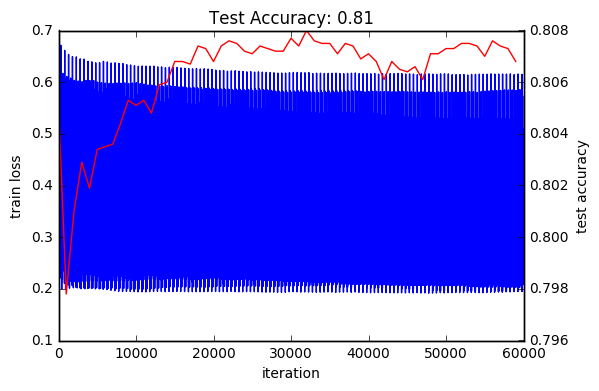

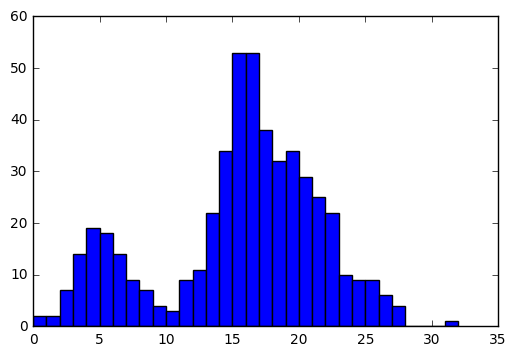

('shape of code and codebook is ', (500,), array([[ -2.55239140e-02],
       [ -2.18092054e-02],
       [ -1.95473470e-02],
       [ -1.76177789e-02],
       [ -1.51463514e-02],
       [ -1.20544070e-02],
       [ -9.83167347e-03],
       [ -7.46185752e-03],
       [ -4.97339945e-03],
       [ -1.84805086e-03],
       [ -1.98141988e-05],
       [  3.62436939e-03],
       [  6.18254812e-03],
       [  8.67332146e-03],
       [  1.11797545e-02],
       [  1.36810923e-02],
       [  1.59786139e-02],
       [  1.84510686e-02],
       [  2.04937495e-02],
       [  2.26835832e-02],
       [  2.53726970e-02],
       [  2.80433204e-02],
       [  3.05062588e-02],
       [  3.33175659e-02],
       [  3.69654298e-02],
       [  3.94634418e-02],
       [  4.22885716e-02],
       [  4.44395654e-02],
       [  4.72395085e-02],
       [  4.98440824e-02],
       [  5.24486564e-02],
       [  5.50532304e-02]], dtype=float32))
('toplevel shape nonzero is', 500)
starting training
('accuracy for this ite

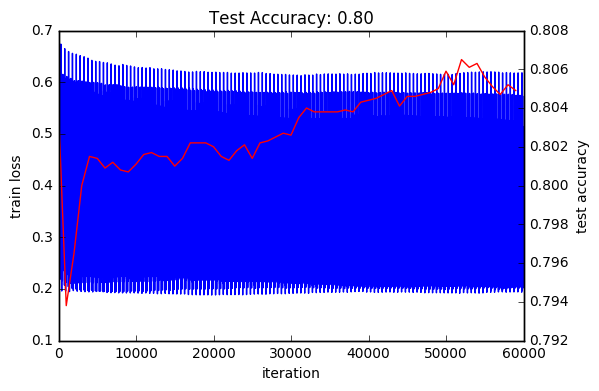

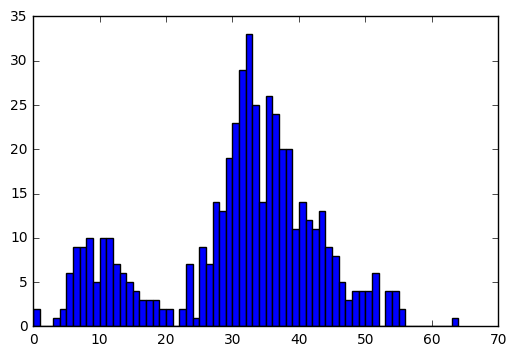

('shape of code and codebook is ', (500,), array([[-0.02552391],
       [-0.02440695],
       [-0.02312533],
       [-0.02247161],
       [-0.02074712],
       [-0.019414  ],
       [-0.01804234],
       [-0.01659582],
       [-0.01514739],
       [-0.01424245],
       [-0.01257226],
       [-0.01130071],
       [-0.01002781],
       [-0.0090537 ],
       [-0.00765171],
       [-0.00659943],
       [-0.00545066],
       [-0.00411286],
       [-0.00213362],
       [-0.00088742],
       [ 0.00036203],
       [ 0.00122537],
       [ 0.00256138],
       [ 0.00392808],
       [ 0.00500293],
       [ 0.00621459],
       [ 0.00752473],
       [ 0.0089874 ],
       [ 0.01022798],
       [ 0.01144176],
       [ 0.01282058],
       [ 0.01399218],
       [ 0.01530816],
       [ 0.01661172],
       [ 0.01778207],
       [ 0.01889901],
       [ 0.02034897],
       [ 0.02186309],
       [ 0.0231111 ],
       [ 0.02466366],
       [ 0.02562525],
       [ 0.02694706],
       [ 0.02818573],
       [ 0.

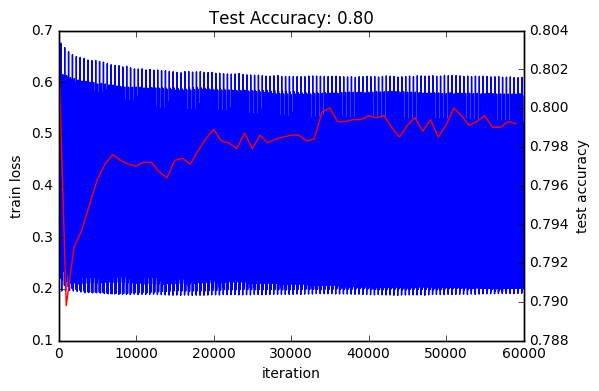

In [26]:
from scipy.cluster.vq import vq, kmeans, whiten, kmeans2

numClusters=[2,4,8,16,32,64]
final_acc=[]
for nc in numClusters:
    print('running for clusters',nc)
    final_acc.append(top_level_training(solver,nc,mask500,data500,reference500,'ip1',niter=60000))
    print('final_acc')

In [29]:
print(len(np.unique(solver.net.params['ip1'][0].data[:])))
print(len(np.nonzero(solver.net.params['ip1'][0].data[:])[0]))


54
500


In [30]:
print(final_acc)

[0.8004, 0.80000000000000004, 0.80730000000000002, 0.80679999999999996, 0.80489999999999995, 0.79920000000000002]


('toplevel shape nonzero is', 500)


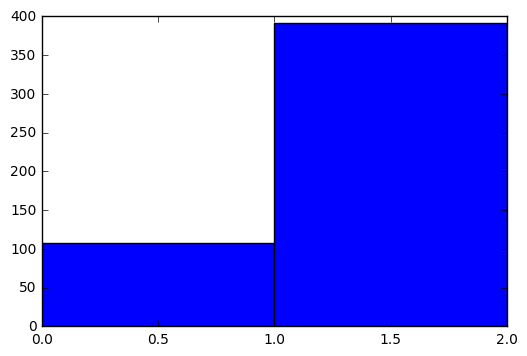

('shape of code and codebook is ', (500,), array([[-0.0110866 ],
       [ 0.02029258]], dtype=float32))
('toplevel shape nonzero is', 500)
starting training
('accuracy for this iteration is', 0.78349999999999997)
('accuracy for this iteration is', 0.80189999999999995)
('accuracy for this iteration is', 0.8034)
('accuracy for this iteration is', 0.80500000000000005)
('accuracy for this iteration is', 0.80520000000000003)
('accuracy for this iteration is', 0.80430000000000001)
('accuracy for this iteration is', 0.80400000000000005)
('accuracy for this iteration is', 0.80469999999999997)
('accuracy for this iteration is', 0.80379999999999996)
('accuracy for this iteration is', 0.80389999999999995)
('accuracy for this iteration is', 0.80349999999999999)
('accuracy for this iteration is', 0.8034)
('accuracy for this iteration is', 0.80310000000000004)
('accuracy for this iteration is', 0.8034)
('accuracy for this iteration is', 0.8044)
('accuracy for this iteration is', 0.80410000000000004)

0.80320000000000003

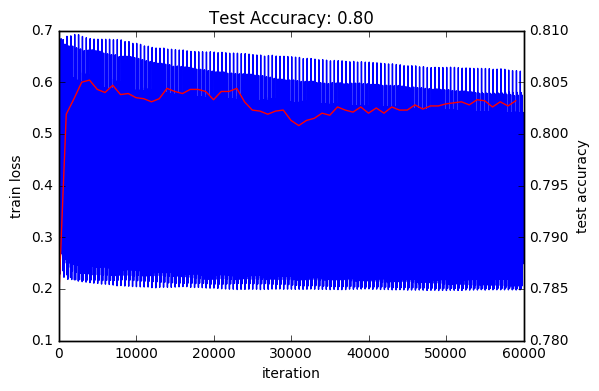

In [32]:
layername='ip1'
learning_rate=0.0001
momentum=0.9
niter=60000
refresh_solver(solver,data500,reference500,layername)
print('toplevel shape nonzero is',len(np.nonzero(solver.net.params[layername][0].data[:])[0]))
code,codebook = cluster_trained_weights(solver,2,layername)
print('shape of code and codebook is ',code.shape,codebook)
solver.net.params[layername][0].data[:]=np.copy(quantize_weights(solver,codebook,code,layername))
print('toplevel shape nonzero is',len(np.nonzero(solver.net.params[layername][0].data[:])[0]))
velocity=np.zeros(codebook.shape) #TODO: possible bug. Check how velocity is initialized
quantized_training_step(solver,codebook,code,mask500,learning_rate,velocity,momentum,layername)
training_loop(solver,niter,codebook,code,mask500,learning_rate,velocity,momentum,layername)

    

In [34]:
clustered_ip1=solver.net.params['ip1'][0].data[:]
print(len(np.unique(clustered_ip1)))
print(len(np.nonzero(clustered_ip1)[0]))
savecode=np.copy(code)
savecodebook=np.copy(codebook)
print(np.unique(clustered_ip1))

3
500
[-0.00893524  0.          0.01950804]


In [35]:
#retest pruned solver after loading the relevant model.
solver.net.copy_from('/home/super/ISHA/Deep_Learning/16Nov/neuron_wise_exhaustive/p500_c2_fc1.caffemodel.h5')
solver.test_nets[0].copy_from('/home/super/ISHA/Deep_Learning/16Nov/neuron_wise_exhaustive/p500_c2_fc1.caffemodel.h5')
solver.net.params[layername][0].data[:]*=mask500
solver.net.params[layername][0].data[:]=np.copy(quantize_weights(solver,codebook,code,layername))
solver.test_nets[0].params[layername][0].data[:]=np.copy(solver.net.params[layername][0].data[:])

print('number of nonzero weights are ',len(np.nonzero(solver.net.params['ip1'][0].data[:])[0]))

correct = 0
for test_it in range(100):
    solver.test_nets[0].forward()
    correct += sum(solver.test_nets[0].blobs['ip1'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
print('accuracy is ',correct/1e4)

('number of nonzero weights are ', 500)
('accuracy is ', 0.80079999999999996)


## HUFFMAN ENCODING 

#### The pruned and clustered weights are encoded via the lossless compression technique of Huffman encoding.
#### The following code creates the Huffman Tree and returns the encoding as two hashmaps that transform from value to huffman index and the reverse, from Huffman index to value

In [36]:
import heapq

#Huffman Encoding
#Frequency Stats directly available in the histogram
def HuffmanTree(freq,CorrBin):

    class Node:
        def __init__(self,freq,val):
            self.freq=freq
            self.val=val
            self.left=None
            self.right=None
            self.idx=''

        #print tree:
    def printInOrder(root):
        if root!=None:
            printInOrder(root.left)
            print(root.freq,root.val)
            printInOrder(root.right)


    heap = [] #min heap to track of next smallest node
    FreqBin=[]
    [FreqBin.append(Node(f,b)) for f,b in zip(freq,CorrBin)]
    
    for fb in FreqBin:
        heapq.heappush(heap,(fb.freq,fb))
    #print(heap)
    
    while len(heap)>1:
        leaf1=heapq.heappop(heap)[1]
        leaf2=heapq.heappop(heap)[1]
        #print('considering elements',leaf1.freq,leaf2.freq)
        internalNode=Node(leaf1.freq+leaf2.freq,'internal')
        internalNode.left=leaf1
        internalNode.right=leaf2
        heapq.heappush(heap,(internalNode.freq,internalNode))

    root=heapq.heappop(heap)[1]
    print('tree is:')
    printInOrder(root)
    return root
    
    

def Encode(elem,idx2val={},val2idx={}):
    if elem.left!=None:
        elem.left.idx=elem.idx+str(0)
        Encode(elem.left,idx2val,val2idx)
    if elem.right!=None:
        elem.right.idx=elem.idx+str(1)
        Encode(elem.right,idx2val,val2idx)
    if elem.left==elem.right==None:
        idx2val[elem.idx]=elem.val
        val2idx[elem.val]=elem.idx
    return idx2val,val2idx

#test Huffman Code:
#freq=[5,9,12,13,16,45]
#CorrBin=['a','b','c','d','e','f']
#root=HuffmanTree(freq,CorrBin)
#print('codes are')
#Encode(root,array=[])

In [38]:
print(np.unique(clustered_ip1))
print(codebook)

[-0.00893524  0.          0.01950804]
[[-0.00893524]
 [ 0.01950804]]


#### Look at what the binary version of the codebook looks like. In this case the Huffman code and the Binary code look the same as there are only 2 clusters. So Implementing Huffman Encoding does not give any additional gains. Howeverit is still implemented in case the user wanted to use more than 2 clusters

In [41]:
print(code)
code_bin=[]
for i in range(len(code)):
    code_bin.append(np.binary_repr(code[i],width=1))

print(code_bin)
#you now want your code to refer to the  Huffman codebook.


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 0 1
 1 1 1 1 0 0 0 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 0 0 0 1 1 0 0 1 1 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 0 1 0 1 1 1 1 0 0 0 1 1 0 0 1 1 1 1 1 0 1 1 0 1 0 0 0 1 1 1 1 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 0 1 1 1 1 1 1 0 0 1 1 1 1
 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1
 1 0 1 0 0 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1
 1 1 1 1 1 0 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 0 0 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 0 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1
 1 1 0 0 1 1 1 1 1 0 0 0 

#### Create the frequency and val inputs to feed to the Huffman Tree

In [43]:
edges_hist=[x for x in range(3)]
frq, edges = np.histogram(code,edges_hist)
total=len(original_data500.flatten())
frq=[x for x in frq]
#frq.append(total-len(code))
edges=[0,1]
#edges.append(-1) #corresponding to all the pruned out elements in the original matrix 
print(frq,edges)

([108, 392], [0, 1])


In [44]:
print(np.unique(code))

[0 1]


In [45]:
root=HuffmanTree(frq,edges)
Huffmanidx2val,Huffmanval2idx=Encode(root)
print(Huffmanidx2val,Huffmanval2idx)


tree is:
(108, 0)
(500, 'internal')
(392, 1)
({'1': 1, '0': 0}, {0: '0', 1: '1'})


#### Convert the codebook from decimal to huffman code

In [46]:
code_huffman=[0]*len(code)
for i in range(len(code)):
    code_huffman[i]=Huffmanval2idx[code[i]] 
print(code_huffman)
print(np.unique(code_huffman))

['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '0', '1', '1', '1', '1', '1', '1', '0', '0', '1', '1', '1', '1', '0', '1', '1', '1', '1', '1', '0', '0', '0', '1', '1', '1', '1', '1', '0', '1', '0', '1', '1', '1', '1', '1', '0', '1', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '0', '0', '0', '1', '1', '0', '0', '1', '1', '0', '0', '0', '1', '1', '1', '0', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '1', '1', '1', '0', '1', '0', '1', '1', '1', '1', '0', '0', '0', '1', '1', '0', '0', '1', '1', '1', '1', '1', '0', '1', '1', '0', '1', '0', '0', '0', '1', '1', '1', '1', '0', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',

#### Feed in Huffman code, decode it, and ensure that the testing accuracy is unaltered

In [47]:
encoded_weight_matrix=np.empty(original_data500.shape)
# quantizer weights according to codebok and code
def huffman_quantize_weights(solver,codebook,huffman_code,layername):
    original_data=np.copy(solver.net.params[layername][0].data[:])
    weight_conv1_flattened=original_data.flatten()
    nz_idx=np.nonzero(weight_conv1_flattened)
    conv1_flat_changed=np.zeros(weight_conv1_flattened.shape)
    for idx,nzidx in enumerate(nz_idx[0]):
        conv1_flat_changed[nzidx]=codebook[Huffmanidx2val[huffman_code[idx]]]
    conv1_changed=conv1_flat_changed.reshape(original_data.shape)
    return conv1_changed




#retest pruned solver after loading the relevant model.
solver.net.copy_from('/home/super/ISHA/Deep_Learning/16Nov/neuron_wise_exhaustive/p500_c2_fc1.caffemodel.h5')
solver.test_nets[0].copy_from('/home/super/ISHA/Deep_Learning/16Nov/neuron_wise_exhaustive/p500_c2_fc1.caffemodel.h5')
solver.net.params[layername][0].data[:]*=mask500
solver.net.params[layername][0].data[:]=np.copy(huffman_quantize_weights(solver,codebook,code_huffman,'ip1'))
solver.test_nets[0].params[layername][0].data[:]=np.copy(solver.net.params[layername][0].data[:])

#solver.net.params['conv1'][0].data[:]=np.copy(original_data750)
print('number of nonzero weights are ',len(np.nonzero(solver.net.params['ip1'][0].data[:])[0]))

correct = 0
for test_it in range(100):
    solver.test_nets[0].forward()
    correct += sum(solver.test_nets[0].blobs['ip1'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
print('accuracy is ',correct/1e4)



solver.net.params[layername][0].data[:]=np.copy(huffman_quantize_weights(solver,codebook,code_huffman,'ip1'))
print('toplevel shape nonzero is',len(np.nonzero(solver.net.params[layername][0].data[:])[0]))
print('toplevel number of unique elements is',len(np.unique(solver.net.params[layername][0].data[:])))


    

('number of nonzero weights are ', 500)
('accuracy is ', 0.80079999999999996)
('toplevel shape nonzero is', 500)
('toplevel number of unique elements is', 3)


#### See how much you are saving with Huffman Encoding

In [48]:
total=0
for i in range(len(code_huffman)):
    total+=len(code_huffman[i])
print('total bits used for the huffman codebook are ', total)
print('average number of bits per weight are :',float(total)/float(len(code_huffman)))

('total bits used for the huffman codebook are ', 500)
('average number of bits per weight are :', 1.0)


# SUMMARY:

We have pruned, quantized and encoded the ip1 layer of Caffe's default CIFAR10 network.  
1)  Inititally the layer had 10241 32bit weights.   
    Total memory used for this layer: 10240*32/8 = 40 KB  
2) After pruning there were 500 weights of 32 bits, without loss of accuracy  
    Total memory is now 2KB to store the non-zero weights and 1.2KB to store the indexes of the zero weights   
3) After quantization there were in essence 2 weights, shared between the 500 non-zero connections. These weights were still 32 bits, but the indexing required 1 bit each.  
    Total memory is now 8Bytes to store the weight values, and 281Bytes to store the indexes of non-zero weights, 1.2KB  to store the indexes of the zero weights  
4) After Huffman encoding, the indexing required 1 bits on average. (This did not change as the number of clusters were just 2)      
  
    
#### So the layer which was 40KB has come  down to 1.5KB , a 26X reduction approximately in the fully connected layer.  